1. Download the MNIST dataset and create a dataloader that adds gaussian noise to the input images.
2. Design and train an AutoEncoder on the MNIST dataset to denoise the noisy images.
3. Randomly choose one image for each digit and visualize the initial images and their corresponding noisy images and decoded images side by side.
4. Compute latent feature vectors of images. (The output of the encoder network)
5. Use PCA to reduce the dimensionality of latent features to 2 and visualize the data points in a scatter plot. Use a different color for each digit.
6. Repeat the previous step with TSNE.
7. What do you conclude from steps 4 and 5 about the learned latent representation of the data?

Bonus:
1. Create a data loader that rotates input images with a random degree.
2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.

Useful links:
- [AE](https://medium.com/@AnasBrital98/autoencoders-explained-da131e60e02a)
- [VAE](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- [PCA](https://towardsdatascience.com/the-most-gentle-introduction-to-principal-component-analysis-9ffae371e93b#:~:text=From%20Wikipedia%2C%20PCA%20is%20a,find%20unmeasured%20%E2%80%9Clatent%20variables%E2%80%9D.)
- [T-SNE](https://towardsdatascience.com/t-sne-clearly-explained-d84c537f53a)

In [2]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torch.utils.data import Dataset, DataLoader, random_split


from tqdm import tqdm

# Answer 1.

In [3]:
mnist_train_data = datasets.MNIST(root='data',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

mnist_test_data = datasets.MNIST(root='data',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

In [5]:
class NoisyDataset(Dataset):
    def __init__(self, dataset, std = 0.25, mean = 0):

        self.original_images = dataset
        self.std = std
        self.mean = mean
        self.load_data(self.original_images)
        self.noisy_images = self.add_noise(self.noisy_images)
    
    def load_data(self, dataset):
        loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)
        for data, _ in loader:
            self.noisy_images = data
    
    def add_noise(self, image):
        return image + self.std * torch.randn(image.shape) + self.mean

    def __getitem__(self, index):
        return self.original_images[index][0], self.noisy_images[index], self.original_images[index][1]

    def __len__(self):
        return len(self.original_images)

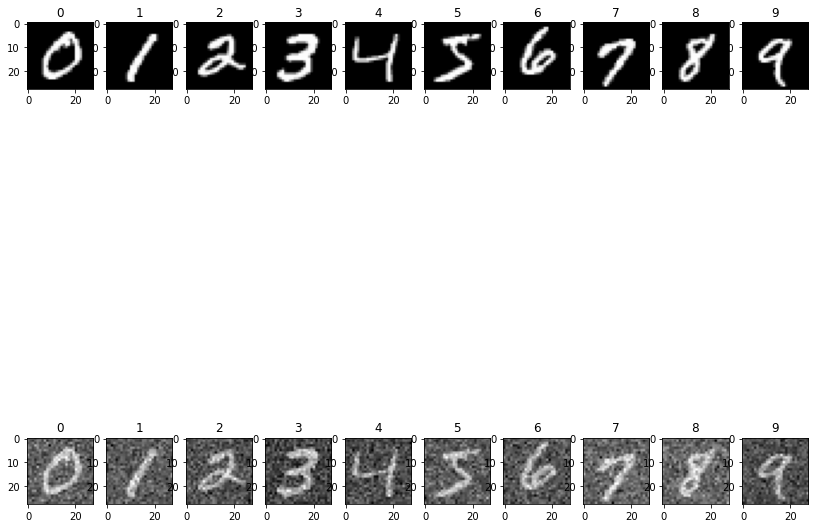

In [6]:
noisy_train_data = NoisyDataset(mnist_train_data)
noisy_test_data = NoisyDataset(mnist_test_data)
random_index = np.random.randint(0, len(noisy_train_data))
numbers = {}
plt.figure(figsize=(14,14))
for i in range(10):
    for j in range(len(noisy_train_data)):
        if noisy_train_data[j][2] == i:
            numbers[i] = j
            break
for i in range(10):
    plt.subplot(2, 10, i+1)
    plt.title(f'{noisy_train_data[numbers[i]][2]}')
    plt.imshow(noisy_train_data[numbers[i]][0].squeeze(), cmap='gray')
    # plt.axis('off')
for i in range(10):
    plt.subplot(2, 10, i+1+10)
    plt.title(f'{noisy_train_data[numbers[i]][2]}')
    plt.imshow(noisy_train_data[numbers[i]][1].numpy().squeeze(), cmap='gray')
    # plt.axis('off')
plt.show()

# Answer 2.

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
batch_size = 128
val_rate = 0.1
num_workers = 1
num_epochs = 10

In [9]:
train_len = int((1 - val_rate) * len(noisy_train_data))
validation_len = len(noisy_train_data) - train_len

train_set, validation_set = random_split(noisy_train_data, [train_len, validation_len])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(noisy_test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [15]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(True),
            nn.Linear(512, 328),
            nn.ReLU(True),
            nn.Linear(328, 10)
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 328),
            nn.ReLU(),
            nn.Linear(328, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, 3, stride=3, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2, stride=2),
        #     nn.Conv2d(16, 8, 3, stride=2, padding=1),
        #     nn.ReLU(True),
        #     nn.MaxPool2d(2, stride=1)
        # )
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(8, 16, 3, stride=2),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
        #     nn.ReLU(True),
        #     nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
        #     nn.Tanh()
        # )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
model = AutoEncoder().to(device)
print(sum(p.numel() for p in model.parameters()))

1147722


In [17]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

In [18]:
def train_val (model, trainloader, val_loader, f_loss, optimizer, n_epochs, device = device):
    for epoch in range(n_epochs):
        train_loss, val_loss = 0, 0
        model.train()
        for _,data,_ in tqdm(train_loader):
            data = data.view(data.size(0), -1).to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = f_loss(output, data)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * data.size(0)

        train_loss /= len(trainloader.dataset)

        model.eval()
        with torch.no_grad():
          for _, data, _ in tqdm(val_loader):
              data = data.view(data.size(0), -1).to(device)
              output = model(data)
              loss = f_loss(output, data)
              val_loss += loss.item() * data.size(0)

        val_loss /= len(val_loader.dataset)
        # scheduler.step(val_loss)

        print(f"[Epoch {epoch}]\t"
            f"Train Loss: {train_loss:.4f}\t"
            f"Validation Loss: {val_loss:.4f}\t")
    return train_loss, val_loss

In [19]:
# Call the train_val function
train_loss, val_loss = train_val(model, train_loader, val_loader, criterion, optimizer, num_epochs)

100%|██████████| 47/47 [00:01<00:00, 35.68it/s]


[Epoch 0]	Train Loss: 0.1031	Validation Loss: 0.0914	


100%|██████████| 47/47 [00:01<00:00, 35.58it/s]


[Epoch 1]	Train Loss: 0.0888	Validation Loss: 0.0873	


100%|██████████| 47/47 [00:01<00:00, 35.20it/s]


[Epoch 2]	Train Loss: 0.0864	Validation Loss: 0.0860	


100%|██████████| 47/47 [00:01<00:00, 35.55it/s]


[Epoch 3]	Train Loss: 0.0856	Validation Loss: 0.0855	


100%|██████████| 47/47 [00:01<00:00, 34.62it/s]


[Epoch 4]	Train Loss: 0.0851	Validation Loss: 0.0851	


100%|██████████| 47/47 [00:01<00:00, 34.49it/s]


[Epoch 5]	Train Loss: 0.0847	Validation Loss: 0.0849	


100%|██████████| 47/47 [00:01<00:00, 35.02it/s]


[Epoch 6]	Train Loss: 0.0845	Validation Loss: 0.0845	


100%|██████████| 47/47 [00:01<00:00, 33.48it/s]


[Epoch 7]	Train Loss: 0.0843	Validation Loss: 0.0845	


100%|██████████| 47/47 [00:01<00:00, 34.70it/s]


[Epoch 8]	Train Loss: 0.0841	Validation Loss: 0.0841	


100%|██████████| 47/47 [00:01<00:00, 34.03it/s]

[Epoch 9]	Train Loss: 0.0840	Validation Loss: 0.0840	


# Answer 3.

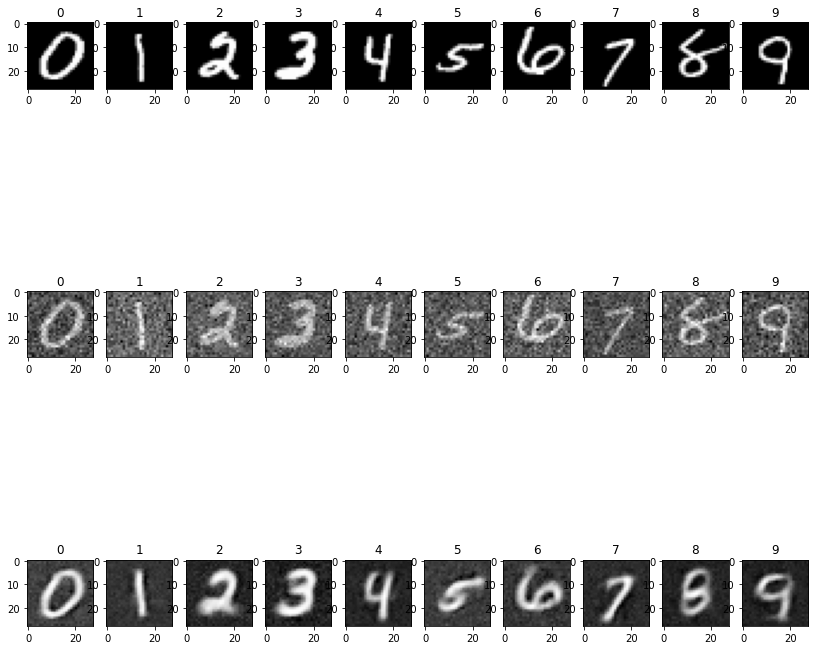

In [21]:
noisy_imgs = {}
original_imgs = {}
for data in test_loader:
  original, noisy, labels = data
  for i in range(len(labels)):
    number = int(labels[i])
    if number not in noisy_imgs:
      noisy_imgs[number] = noisy[i]
      original_imgs[number] = original[i]
    if len(noisy_imgs) == 10:
      break
  if len(noisy_imgs) == 10:
      break

plt.figure(figsize=(14, 14))
for i in range(len(noisy_imgs)):
  noisy = noisy_imgs[i]
  noisy = noisy.view(noisy.size(0), -1).to(device)
  decoded = model(noisy).view(1, 28, 28).cpu().detach()
  plt.subplot(3, 10, i+1)
  plt.title(i)
  plt.imshow(original_imgs[i].numpy().squeeze(), cmap='gray')
  plt.subplot(3, 10, i+1+10)
  plt.title(i)
  plt.imshow(noisy_imgs[i].numpy().squeeze(), cmap='gray')
  plt.subplot(3, 10, i+1+20)
  plt.title(i)
  plt.imshow(decoded.numpy().squeeze(), cmap='gray')
plt.show()

# Answer 4.

In [22]:
l_features = []
l_labels = []
for data in test_loader:
  original, img, label = data
  img = img.view(img.size(0), -1).to(device)
  enc = model.encoder(img)
  l_features.append(enc.cpu().detach().numpy())
  l_labels.append(label.cpu().detach().numpy())

# Answer 5.

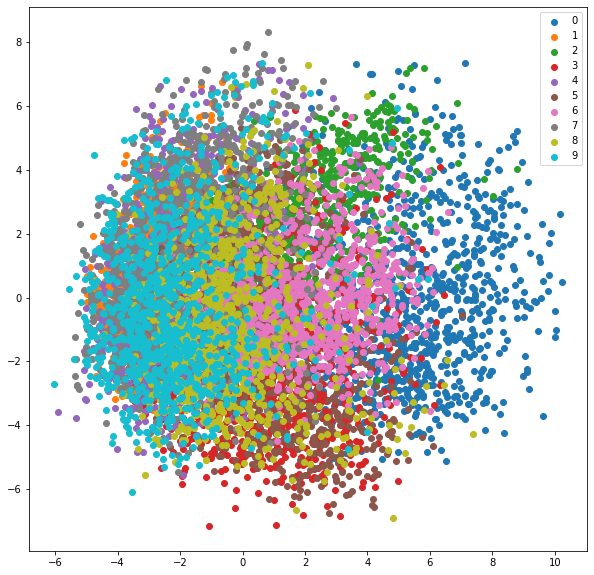

In [24]:
l_features = np.concatenate(l_features, axis=0)
l_labels = np.concatenate(l_labels, axis=0)

pca = PCA(n_components=2)
pca.fit(l_features)
pca_features = pca.transform(l_features)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(pca_features[l_labels == i, 0], pca_features[l_labels == i, 1], label=i)
plt.legend()
plt.show()

# Answer 6.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


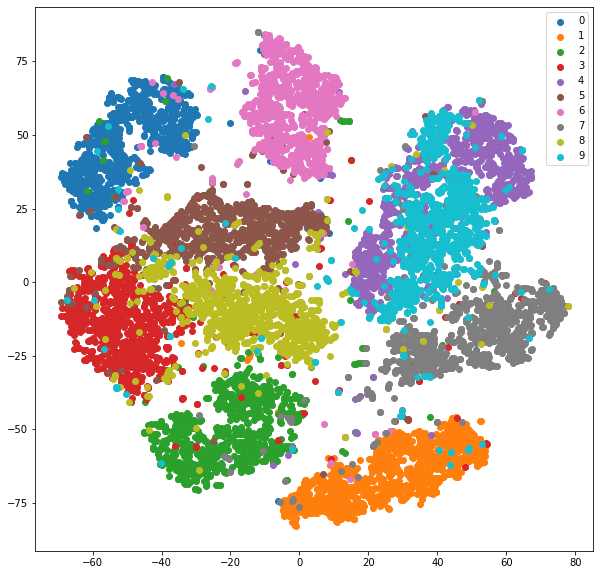

In [25]:
tsne = TSNE(n_components=2)
tsne_features = tsne.fit_transform(l_features)

plt.figure(figsize=(10, 10))
for i in range(10):
    plt.scatter(tsne_features[l_labels == i, 0], tsne_features[l_labels == i, 1], label=i)
plt.legend()
plt.show()

# Answer 7: 
The latent representation of the data is not very good. The PCA and TSNE plots are not very clear and the clusters are not very well defined.

but when we compare PCA and TSNE we can see that TSNE is better at clustering the data. The main reason for this is that PCA is a linear dimensionality reduction technique and TSNE is a non-linear dimensionality reduction technique. In PCA, the clusters are linearly separable but in TSNE, the clusters are not linearly separable. In the above example we can see that the clusters are not linearly separable and TSNE is better at clustering the data and have lower loss than PCA.

# Bonus: Answer 1.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



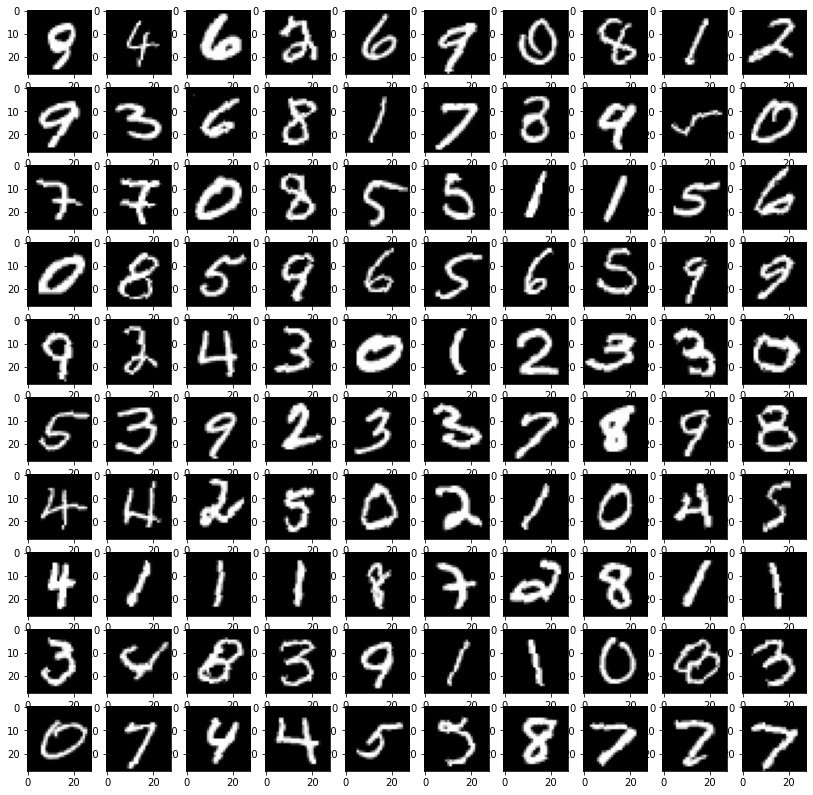

In [26]:
rotate = transforms.RandomRotation(10)
create_data_loader = transforms.Compose([
    transforms.ToTensor(),
    rotate,
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=create_data_loader),
    batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=create_data_loader),
    batch_size=batch_size, shuffle=True)

plt.figure(figsize=(14, 14))
for i, (data, _) in enumerate(train_loader):
    for j in range(10):
        plt.subplot(10, 10, i*10 + j + 1)
        plt.imshow(data[j].numpy().squeeze(), cmap='gray')
    if i == 9:
        break

# Bonus: Answer 2

In [27]:
# 2. Design and train a Variational AutoEncoder that gets rotated images as input and outputs an image so that the digit in the image would become horizontal.
class ConvAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch = model(data)
        loss = criterion(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(val_loader):
            data = data.to(device)
            recon_batch = model(data)
            test_loss += criterion(recon_batch, data).item()
    test_loss /= len(val_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

for epoch in range(1, 10 + 1):
    train(epoch)
    test(epoch)
    

====> Epoch: 1 Average loss: 0.0054
====> Test set loss: 0.0047
====> Epoch: 2 Average loss: 0.0044
====> Test set loss: 0.0043
====> Epoch: 3 Average loss: 0.0042
====> Test set loss: 0.0042
====> Epoch: 4 Average loss: 0.0041
====> Test set loss: 0.0041
====> Epoch: 5 Average loss: 0.0040
====> Test set loss: 0.0040
====> Epoch: 6 Average loss: 0.0040
====> Test set loss: 0.0040
====> Epoch: 7 Average loss: 0.0039
====> Test set loss: 0.0040
====> Epoch: 8 Average loss: 0.0039
====> Test set loss: 0.0040
====> Epoch: 9 Average loss: 0.0039
====> Test set loss: 0.0039
====> Epoch: 10 Average loss: 0.0039
====> Test set loss: 0.0039
